# BigEarthNet - Application to downstream tasks

In [1]:
import torch
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, fbeta_score
from convert_labels import convert_labels
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
train_feat = torch.load('./features/feat-train-bigearthnet.pth')
train_labels = torch.load('./features/labels-train-bigearthnet.pth')
test_feat = torch.load('./features/feat-test-bigearthnet.pth')
test_labels = torch.load('./features/labels-test-bigearthnet.pth')

flattened_train_features = np.array(train_feat.view(-1, 768))
flattened_train_labels = np.array(train_labels.view(-1, 43))
flattened_test_features = np.array(test_feat.view(-1, 768))
flattened_test_labels = np.array(test_labels.view(-1, 43))

In [3]:
print(flattened_train_features.shape)
print(flattened_train_labels.shape)
print(flattened_test_features.shape)
print(flattened_test_labels.shape)

(269696, 768)
(269696, 43)
(125888, 768)
(125888, 43)


In [4]:
train_count = flattened_train_features.shape[0]
test_count = flattened_test_features.shape[0]

In [5]:
# retrieved from https://git.tu-berlin.de/rsim/BigEarthNet-MM_19-classes_models/-/blob/master/label_indices.json?ref_type=heads
class_names = [
        "Continuous urban fabric",
        "Discontinuous urban fabric",
        "Industrial or commercial units",
        "Road and rail networks and associated land",
        "Port areas",
        "Airports",
        "Mineral extraction sites",
        "Dump sites",
        "Construction sites",
        "Green urban areas",
        "Sport and leisure facilities",
        "Non-irrigated arable land",
        "Permanently irrigated land",
        "Rice fields",
        "Vineyards",
        "Fruit trees and berry plantations",
        "Olive groves",
        "Pastures",
        "Annual crops associated with permanent crops",
        "Complex cultivation patterns",
        "Agriculture with a lot of natural vegetation", # shortened from "Land principally occupied by agriculture, with significant areas of natural vegetation",
        "Agro-forestry areas",
        "Broad-leaved forest",
        "Coniferous forest",
        "Mixed forest",
        "Natural grassland",
        "Moors and heathland",
        "Sclerophyllous vegetation",
        "Transitional woodland/shrub",
        "Beaches, dunes, sands",
        "Bare rock",
        "Sparsely vegetated areas",
        "Burnt areas",
        "Inland marshes",
        "Peatbogs",
        "Salt marshes",
        "Salines",
        "Intertidal flats",
        "Water courses",
        "Water bodies",
        "Coastal lagoons",
        "Estuaries",
        "Sea and ocean"
]

In [6]:
def plotMulticlassConfusionMatrix(title, cm, class_names):
    columns = 5
    fig, axs = plt.subplots(math.ceil(len(class_names) / columns), columns, figsize=(20, 20))
    for i, cl_name in enumerate(class_names):
        ax = axs[i // columns][i % columns]
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cm[i].flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm[i].flatten()/np.sum(cm[i])]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm[i], annot=labels, fmt="", cmap='Blues', ax=ax, cbar=False, xticklabels=False, yticklabels=False)
        ax.set_title(cl_name)
    axs[-1, -1].axis('off')
    plt.suptitle("Confusion Matrices - " + title, size=16, y=0.92)
    plt.savefig("images/" + title + " - confusion matrix.png")
    plt.show()

def plotMulticlassF2Scores(title, cm, class_names):
    f2_scores = []
    for i, cl_name in enumerate(class_names):
        tp = cm[i][1][1]
        fp = cm[i][0][1]
        fn = cm[i][1][0]
        f2 = (5 * tp) / (5 * tp + 4 * fn + fp)
        f2_scores.append(f2)
    f2_scores, class_names = zip(*sorted(zip(f2_scores, class_names)))
    
    plt.bar(class_names, f2_scores)
    plt.xticks(rotation=90)
    plt.title("F2-Scores - " + title, size=16)
    plt.savefig("images/" + title + " - f2 scores.png")
    plt.show()

In [7]:
results = {}

## Random Forest

In [8]:
rf_classifier = RandomForestClassifier(
                        n_estimators=20, 
                        criterion='gini', 
                        random_state=42, 
                        max_depth=None,
                        min_samples_split=10,
                        min_samples_leaf=10,
                        max_features='sqrt',
                        max_leaf_nodes=20000,
                        bootstrap=False,
                        n_jobs=-1)
rf_classifier.fit(flattened_train_features[:train_count], flattened_train_labels[:train_count])

RandomForestClassifier(bootstrap=False, max_leaf_nodes=20000,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=20, n_jobs=-1, random_state=42)

In [9]:
test_preds = rf_classifier.predict(flattened_test_features[:test_count])

In [10]:
flattened_test_labels[:test_count].shape

(125888, 43)

Random Forest Result
f2_macro:  0.0945969440692672
f2_micro:  0.33728043856815637
hamming_loss:  0.05607642378311914
Classification Report
                                              precision    recall  f1-score   support

                     Continuous urban fabric       0.70      0.04      0.08      2640
                  Discontinuous urban fabric       0.74      0.12      0.21     15734
              Industrial or commercial units       0.76      0.07      0.12      2808
  Road and rail networks and associated land       0.00      0.00      0.00       510
                                  Port areas       0.00      0.00      0.00        80
                                    Airports       0.00      0.00      0.00       137
                    Mineral extraction sites       0.00      0.00      0.00       478
                                  Dump sites       0.00      0.00      0.00        83
                          Construction sites       0.00      0.00      0.00       159


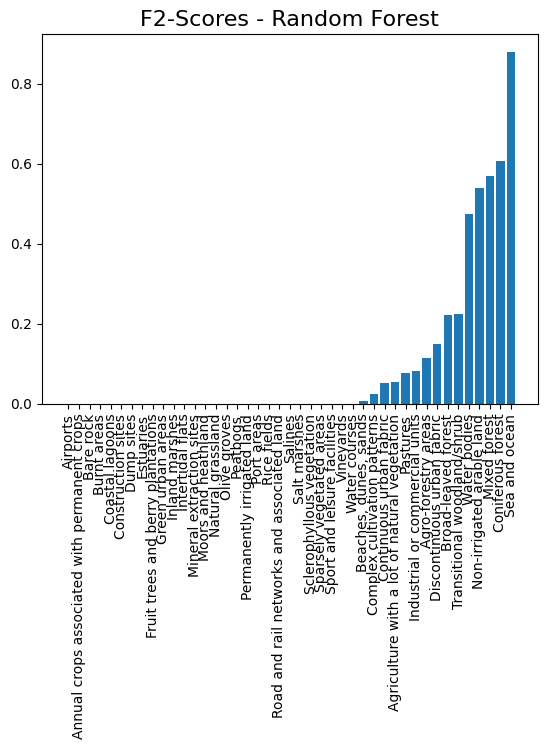

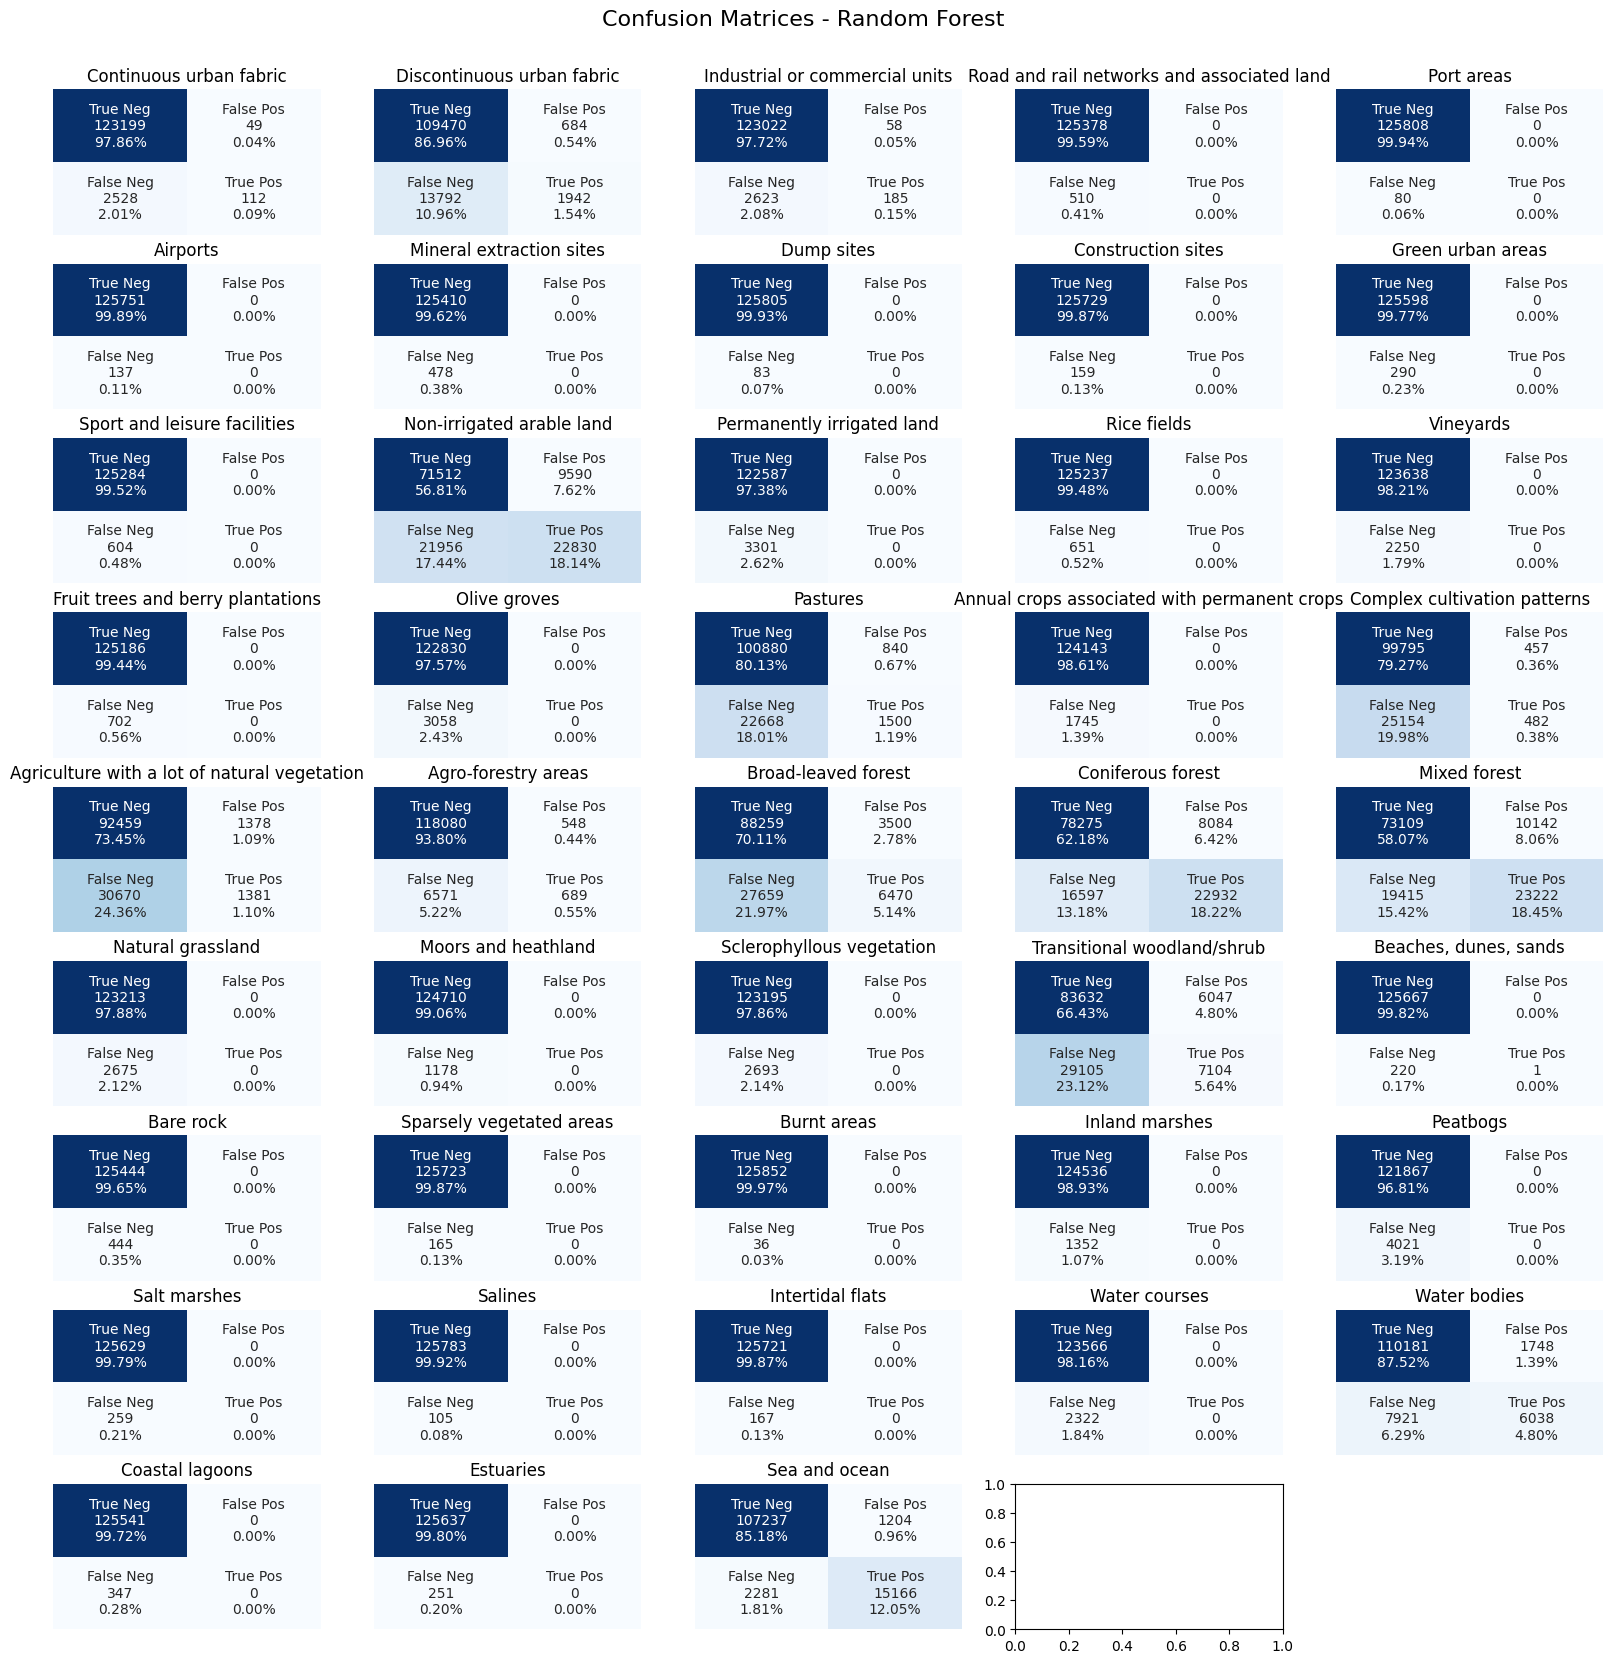

In [11]:
print("Random Forest Result")
fbeta_macro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='macro', beta=2)
fbeta_micro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='micro', beta=2)
hamming_loss_score = hamming_loss(flattened_test_labels[:test_count], test_preds)
results["Random Forest"] = {
    "f2_macro": fbeta_macro,
    "f2_micro": fbeta_micro,
    "hamming_loss": hamming_loss_score
}
print("f2_macro: ", fbeta_macro)
print("f2_micro: ", fbeta_micro)
print("hamming_loss: ", hamming_loss_score)
print("Classification Report")
print(classification_report(flattened_test_labels[:test_count], test_preds, target_names=class_names, zero_division=0))

cm = multilabel_confusion_matrix(flattened_test_labels[:test_count], test_preds)
plotMulticlassF2Scores("Random Forest", cm, class_names)
plotMulticlassConfusionMatrix("Random Forest", cm, class_names)

Comparison to paper:
- f2_macro: about 0.48
- f2_micro: about 0.68
- hamming loss: 4.0 ???

## Linear Probing

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device: ", device)

device:  mps


In [13]:
torch.manual_seed(0)
scaler = StandardScaler()
X_train = scaler.fit_transform(flattened_train_features)
X_test = scaler.transform(flattened_test_features)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(flattened_train_labels, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(flattened_test_labels, dtype=torch.float32).to(device)

In [14]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [17]:
class LinearLayer(nn.Module):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 43),
        )

    def forward(self, x):
        return self.layers(x)

model = LinearLayer().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.1850
Epoch 2, Loss: 0.1358
Epoch 3, Loss: 0.1511
Epoch 4, Loss: 0.1514
Epoch 5, Loss: 0.1446
Epoch 6, Loss: 0.1404
Epoch 7, Loss: 0.1317
Epoch 8, Loss: 0.1438
Epoch 9, Loss: 0.1475
Epoch 10, Loss: 0.1341
Epoch 11, Loss: 0.1373
Epoch 12, Loss: 0.1510
Epoch 13, Loss: 0.1281
Epoch 14, Loss: 0.1495
Epoch 15, Loss: 0.1560
Epoch 16, Loss: 0.1620
Epoch 17, Loss: 0.1524
Epoch 18, Loss: 0.1385
Epoch 19, Loss: 0.1569
Epoch 20, Loss: 0.1603


In [19]:
model.eval()
test_preds = model(X_test) > 0
test_preds = test_preds.cpu().detach().numpy()

Linear Probing result
f2_macro:  0.12629231471127822
f2_micro:  0.3653714818659085
hamming_loss:  0.05749037904493917
Classification Report
                                              precision    recall  f1-score   support

                     Continuous urban fabric       0.18      0.00      0.01      2640
                  Discontinuous urban fabric       0.76      0.25      0.37     15734
              Industrial or commercial units       0.57      0.22      0.31      2808
  Road and rail networks and associated land       0.09      0.01      0.02       510
                                  Port areas       0.28      0.24      0.26        80
                                    Airports       0.00      0.00      0.00       137
                    Mineral extraction sites       0.00      0.00      0.00       478
                                  Dump sites       0.00      0.00      0.00        83
                          Construction sites       0.00      0.00      0.00       159

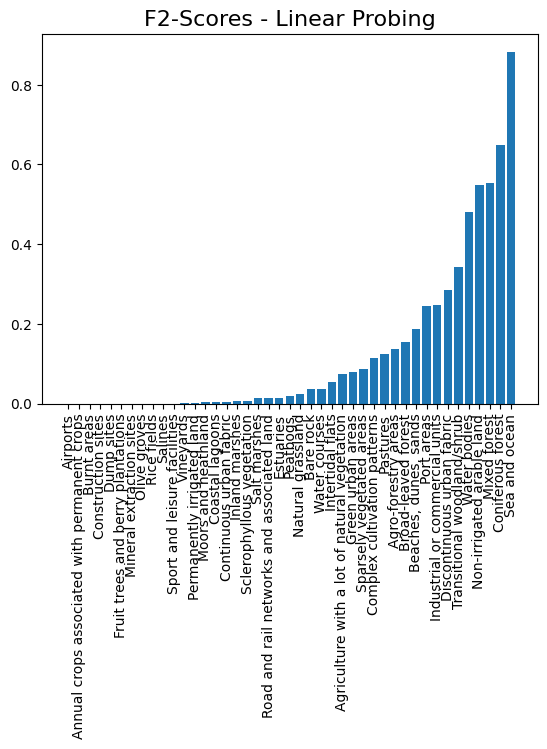

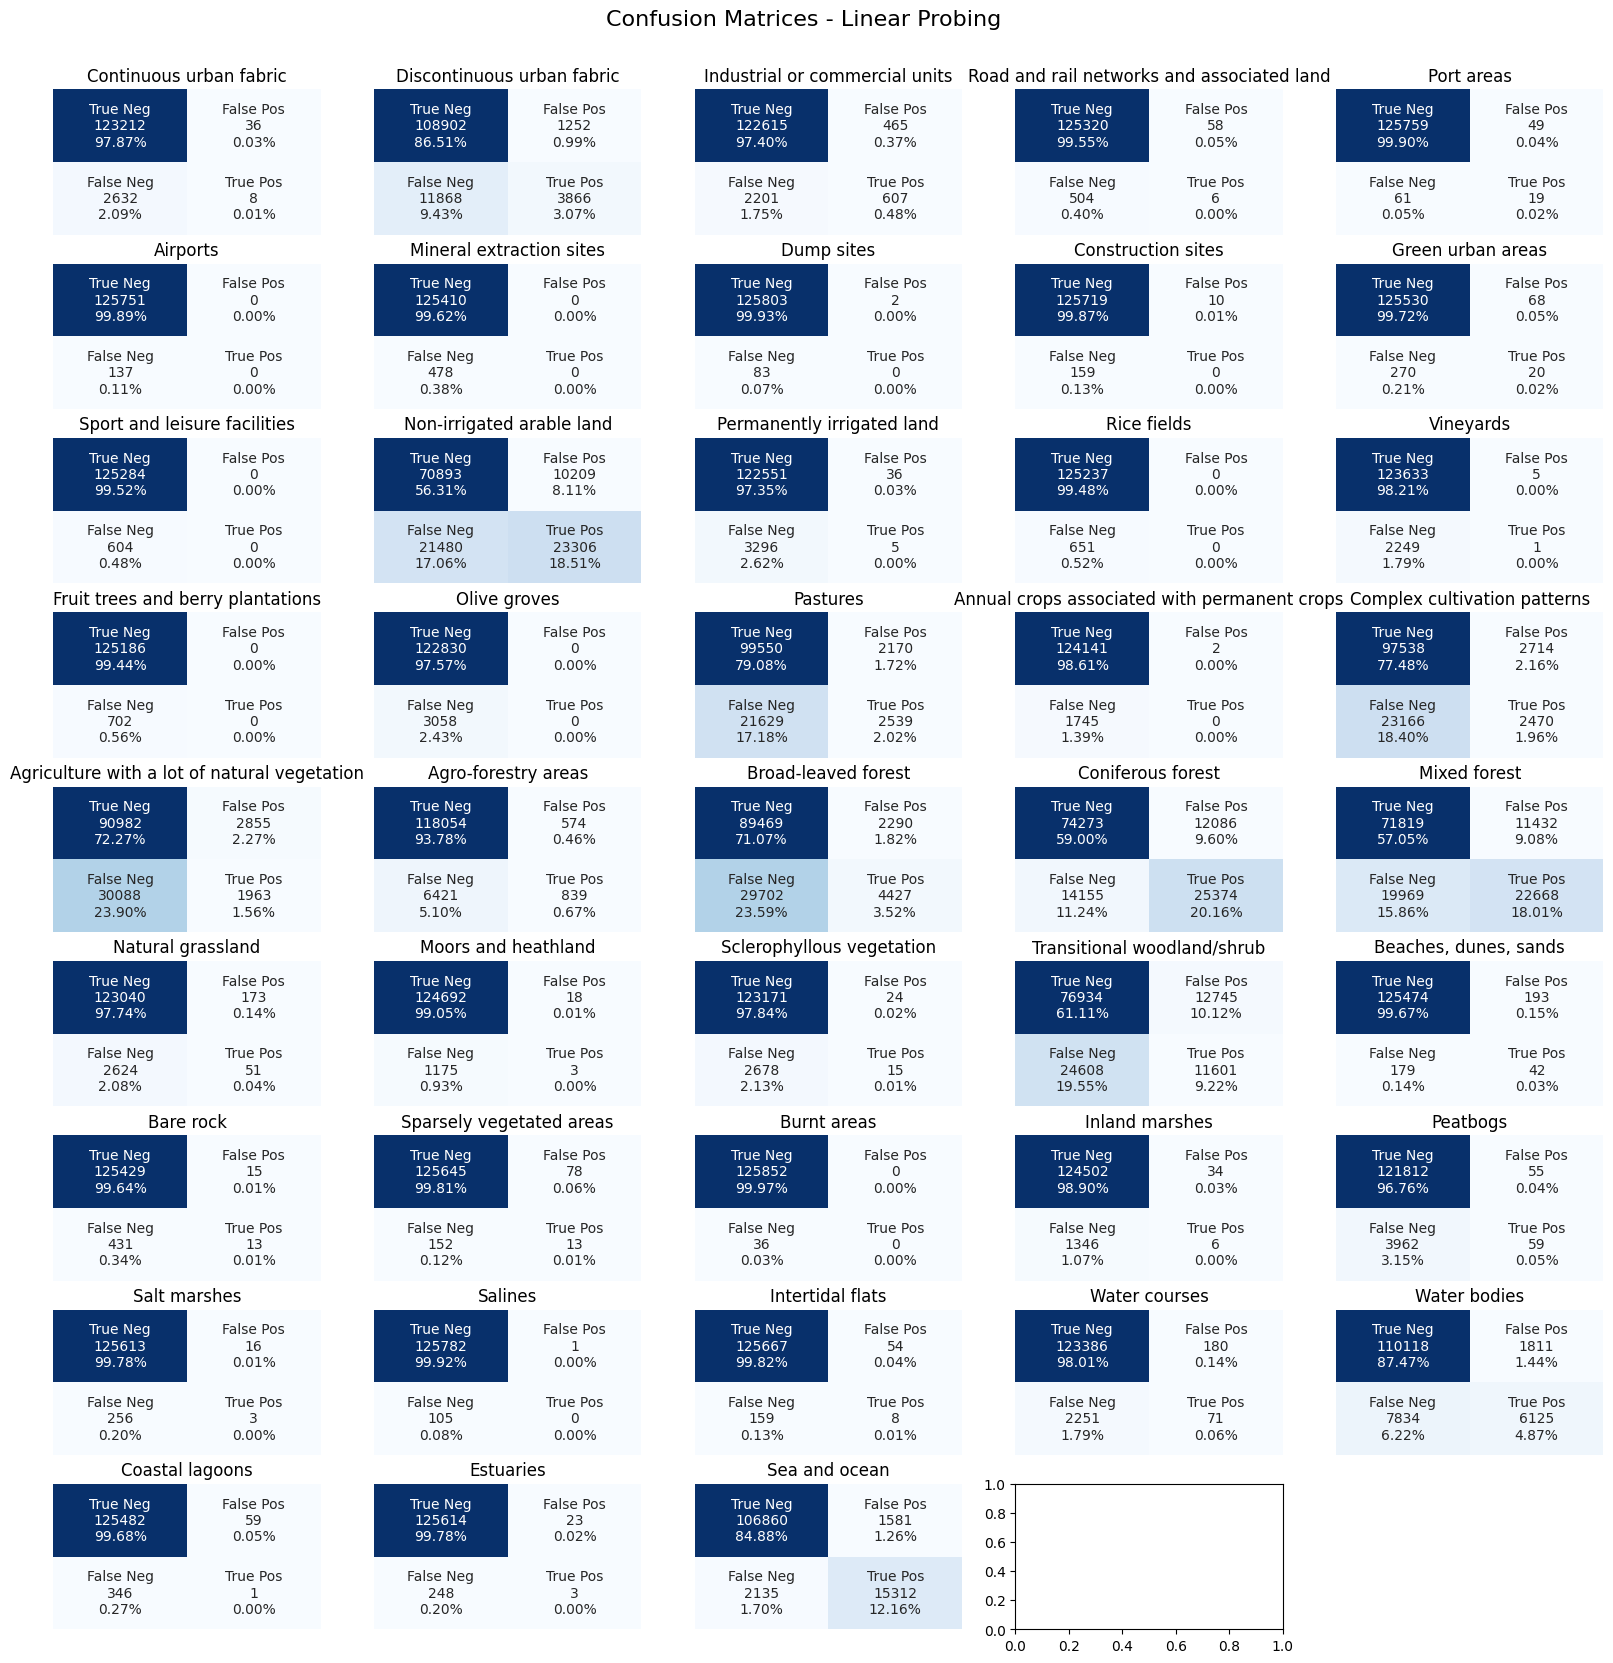

In [20]:
print("Linear Probing result")
fbeta_macro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='macro', beta=2)
fbeta_micro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='micro', beta=2)
hamming_loss_score = hamming_loss(flattened_test_labels[:test_count], test_preds)
results["Linear Probing"] = {
    "f2_macro": fbeta_macro,
    "f2_micro": fbeta_micro,
    "hamming_loss": hamming_loss_score
}
print("f2_macro: ", fbeta_macro)
print("f2_micro: ", fbeta_micro)
print("hamming_loss: ", hamming_loss_score)
print("Classification Report")
print(classification_report(flattened_test_labels[:test_count], test_preds, target_names=class_names, zero_division=0))

cm = multilabel_confusion_matrix(flattened_test_labels[:test_count], test_preds)
plotMulticlassF2Scores("Linear Probing", cm, class_names)
plotMulticlassConfusionMatrix("Linear Probing", cm, class_names)

Comparison to paper:
- f2_macro: about 0.48
- f2_micro: about 0.68
- hamming loss: 4.0 ???
  
## Multi Layer Perceptron

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, 100),
            nn.ReLU(),
            nn.Linear(100, 43)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.1425
Epoch 2, Loss: 0.1358
Epoch 3, Loss: 0.1437
Epoch 4, Loss: 0.1453
Epoch 5, Loss: 0.1354
Epoch 6, Loss: 0.1326
Epoch 7, Loss: 0.1525
Epoch 8, Loss: 0.1334
Epoch 9, Loss: 0.1462
Epoch 10, Loss: 0.1280
Epoch 11, Loss: 0.1399
Epoch 12, Loss: 0.1426
Epoch 13, Loss: 0.1417
Epoch 14, Loss: 0.1221
Epoch 15, Loss: 0.1240
Epoch 16, Loss: 0.1303
Epoch 17, Loss: 0.1318
Epoch 18, Loss: 0.1282
Epoch 19, Loss: 0.1281
Epoch 20, Loss: 0.1412


MLP result
f2_macro:  0.15448114070691368
f2_micro:  0.44456830709733003
hamming_loss:  0.052035364029746636
Classification Report
                                              precision    recall  f1-score   support

                     Continuous urban fabric       0.55      0.03      0.06      2640
                  Discontinuous urban fabric       0.71      0.35      0.47     15734
              Industrial or commercial units       0.61      0.17      0.26      2808
  Road and rail networks and associated land       0.14      0.01      0.01       510
                                  Port areas       0.62      0.12      0.21        80
                                    Airports       0.00      0.00      0.00       137
                    Mineral extraction sites       0.00      0.00      0.00       478
                                  Dump sites       0.00      0.00      0.00        83
                          Construction sites       0.00      0.00      0.00       159
        

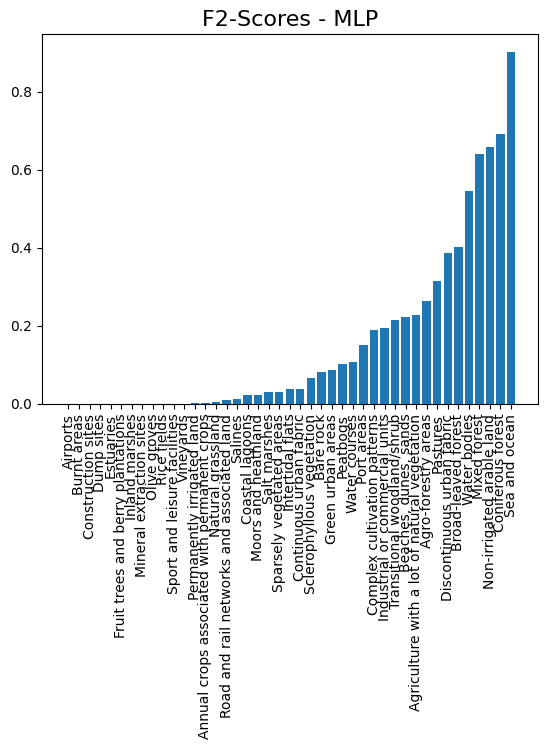

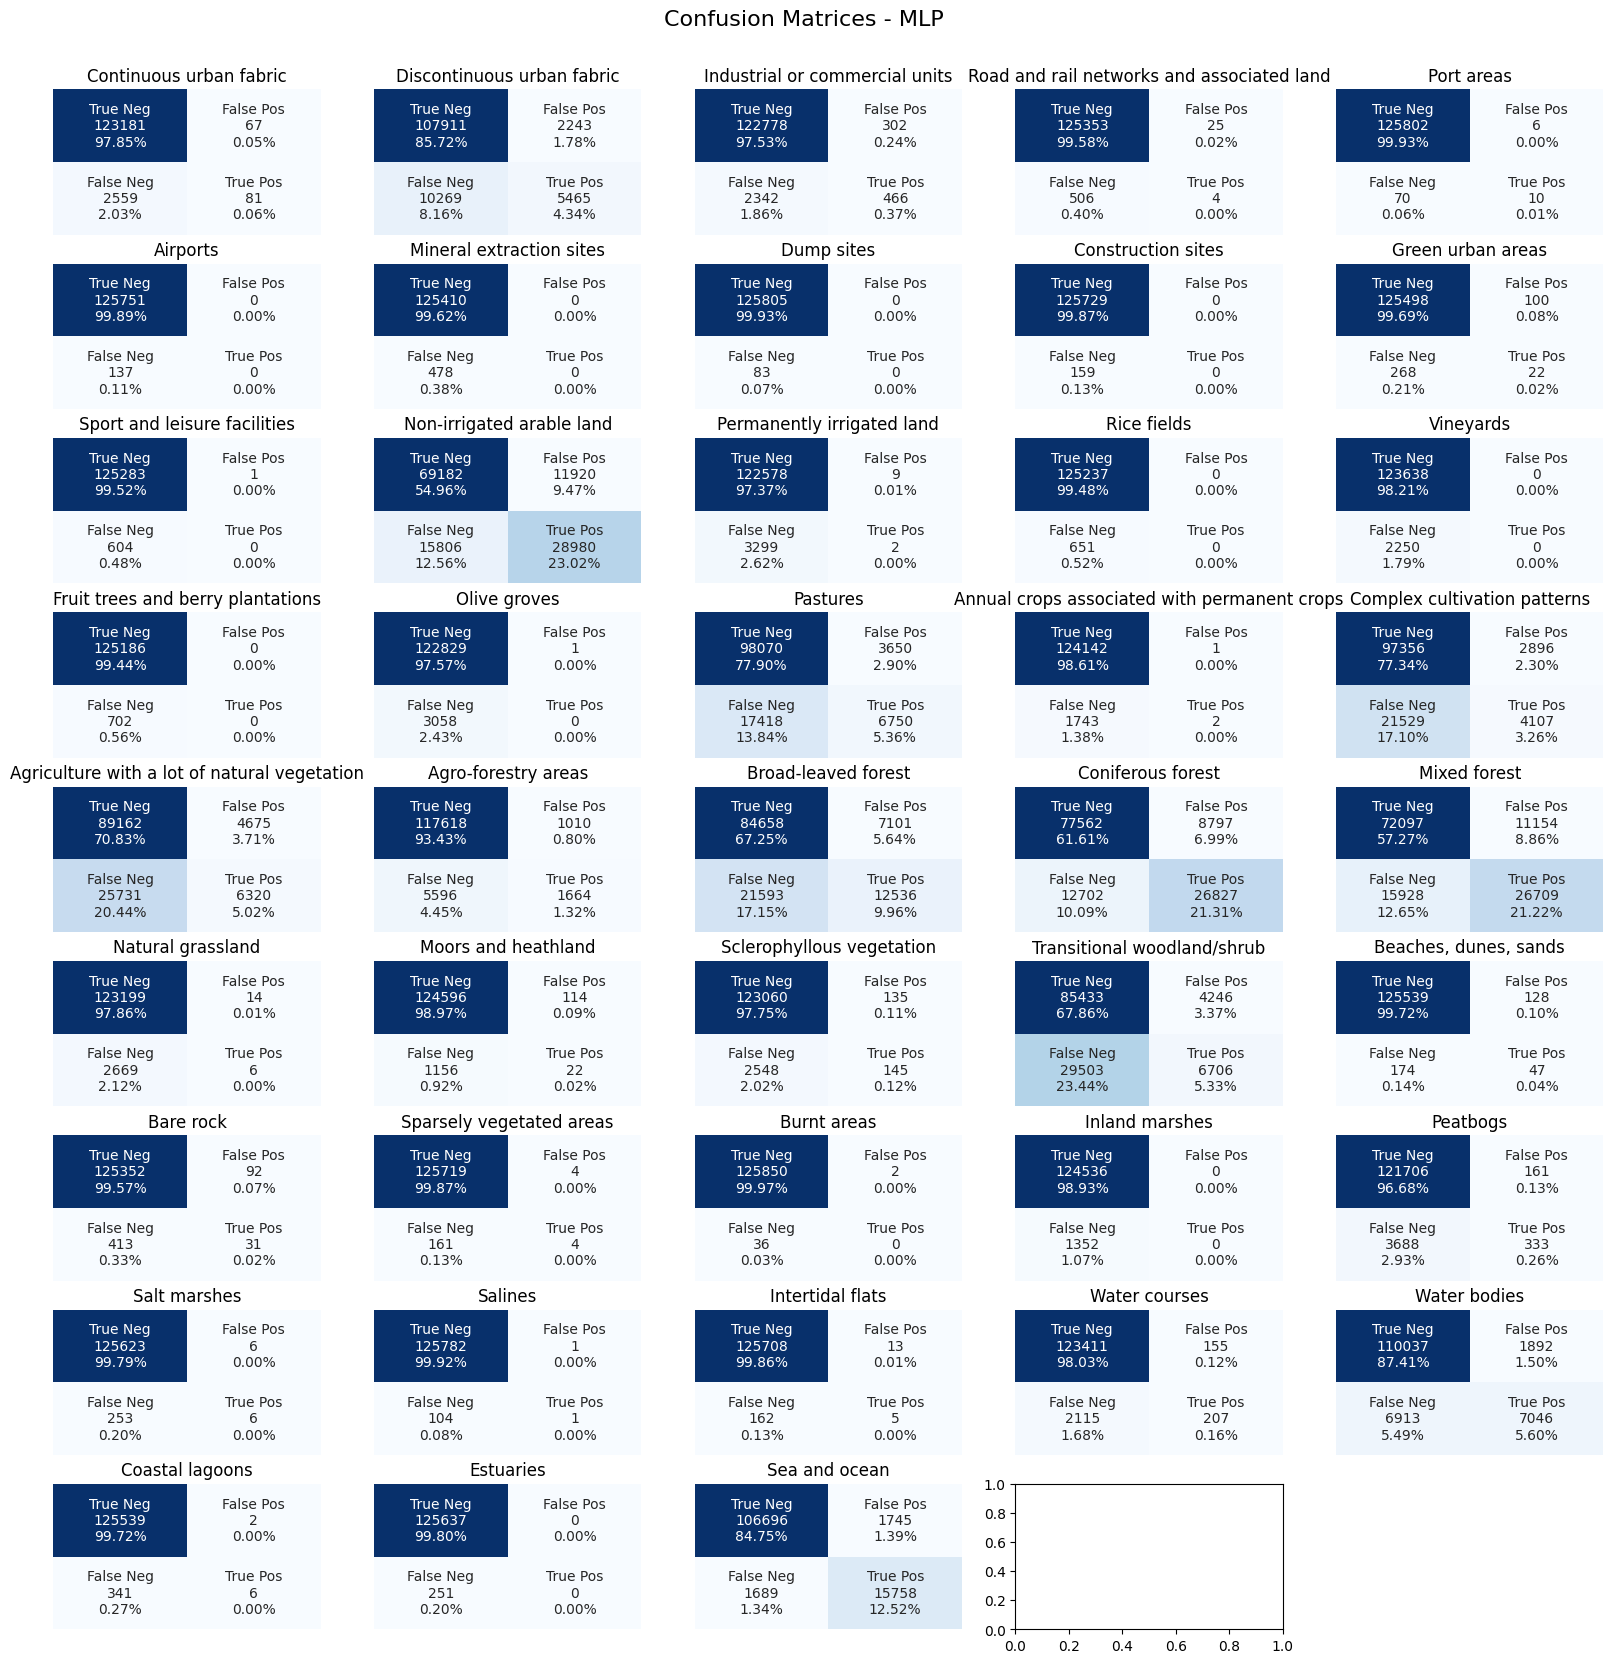

In [23]:
model.eval()
test_preds = model(X_test) > 0
test_preds = test_preds.cpu().detach().numpy()

print("MLP result")
fbeta_macro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='macro', beta=2)
fbeta_micro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='micro', beta=2)
hamming_loss_score = hamming_loss(flattened_test_labels[:test_count], test_preds)
results["MLP"] = {
    "f2_macro": fbeta_macro,
    "f2_micro": fbeta_micro,
    "hamming_loss": hamming_loss_score
}
print("f2_macro: ", fbeta_macro)
print("f2_micro: ", fbeta_micro)
print("hamming_loss: ", hamming_loss_score)
print("Classification Report")
print(classification_report(flattened_test_labels[:test_count], test_preds, target_names=class_names, zero_division=0))

cm = multilabel_confusion_matrix(flattened_test_labels[:test_count], test_preds)
plotMulticlassF2Scores("MLP", cm, class_names)
plotMulticlassConfusionMatrix("MLP", cm, class_names)

Comparison to paper:
- f2_macro: about 0.48
- f2_micro: about 0.68
- hamming loss: 4.0 ???

## Comparison

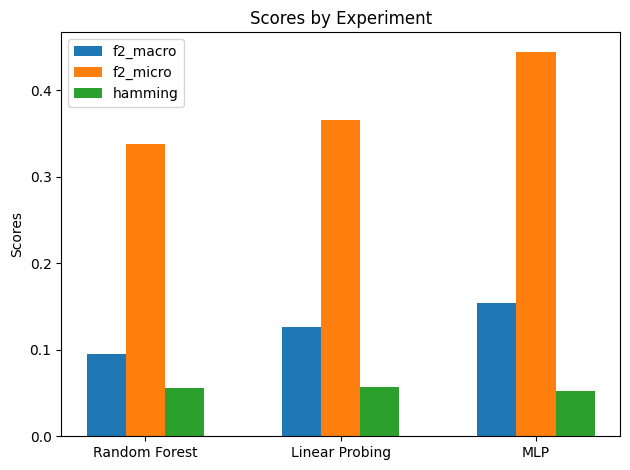

In [24]:
f2_macros = []
f2_micros = []
hamming = []
for key in results:
    f2_macros.append(results[key]["f2_macro"])
    f2_micros.append(results[key]["f2_micro"])
    hamming.append(results[key]["hamming_loss"])

x = np.arange(len(results.keys()))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, f2_macros, width, label='f2_macro')
rects2 = ax.bar(x, f2_micros, width, label='f2_micro')
rects3 = ax.bar(x + width, hamming, width, label='hamming')

ax.set_ylabel('Scores')
ax.set_title('Scores by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(results.keys())
ax.legend()

fig.tight_layout()
plt.title("Scores by Experiment")
plt.savefig("images/scores by experiment.png")
plt.show()